<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageGeneration/code/VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install -q tensorflow-probability

# Module

In [2]:
import numpy as np 
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp 
import tensorflow as tf

# VectorQuantizer

In [24]:
embedding_dim = 16
num_embeddings = 64
w_init = tf.random_uniform_initializer()
embeddings = tf.Variable(
        initial_value = w_init(
            shape = (embedding_dim,num_embeddings),dtype='float32'
        ))

embeddings.shape

TensorShape([16, 64])

In [30]:
x = tf.random.uniform(shape=[28,28,1])
input_shape = tf.shape(x)
print(input_shape)
flattened = tf.reshape(x,[-1,embedding_dim])
flattened.shape

tf.Tensor([28 28  1], shape=(3,), dtype=int32)


TensorShape([49, 16])

In [35]:
similarity = tf.matmul(flattened, embeddings)
distances = (
    tf.reduce_sum(flattened ** 2, axis=1, keepdims=True)
    + tf.reduce_sum(embeddings ** 2, axis=0)
    - 2 * similarity
)
encoding_indices = tf.argmin(distances,axis=1)
encoding_indices

<tf.Tensor: shape=(49,), dtype=int64, numpy=
array([53, 57, 57, 44, 53, 44, 49, 53, 53, 57, 44, 53, 27, 57, 44, 44, 53,
       53, 44, 53, 44, 44, 44, 44, 53, 27, 27, 44, 53, 53, 44, 53, 57, 53,
       57, 53, 53, 53, 44, 24, 53, 53, 53, 44, 27, 27, 27, 57, 44])>

In [40]:
encodings = tf.one_hot(encoding_indices,num_embeddings)
quantized = tf.matmul(encodings,embeddings,transpose_b=True) 
quantized = tf.reshape(quantized,input_shape)
quantized.shape

TensorShape([28, 28, 1])

In [9]:
class VectorQuantizer(layers.Layer):
  def __init__(self, num_embeddings, embedding_dim, beta=0.25,**kwargs):
    super().__init__(**kwargs)
    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.beta = beta

    w_init = tf.random_uniform_initializer()
    self.embeddings = tf.Variable(
        initial_value = w_init(
            shape = (self.embedding_dim,self.num_embeddings),dtype='float32'
        ),
        trainable=True,
        name = 'embeddings_vqvae'
    )

  def call(self,x):
    input_shape = tf.shape(x)
    flattened = tf.reshape(x,[-1,self.embedding_dim])

    # Quantization
    encoding_indices = self.get_code_indices(flattened)
    encodings = tf.one_hot(encoding_indices,self.num_embeddings)
    quantized = tf.matmul(encodings,self.embeddings,transpose_b=True) 

    quantized = tf.reshape(quantized,input_shape)

    commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized)-x)**2)
    codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x))**2)
    self.add_loss(self.beta*commitment_loss + codebook_loss)

    quantized = x + tf.stop_gradient(quantized - x)
    return quantized


  def get_code_indices(self,flattened_inputs):
    similarity = tf.matmul(flattened_inputs, self.embeddings)
    distances = (
        tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
        + tf.reduce_sum(self.embeddings ** 2, axis=0)
        - 2 * similarity
    )

    encoding_indices = tf.argmin(distances,axis=1)
    return encoding_indices

# Encoder Decoder

In [10]:
def get_encoder(latent_dim=16):
  encoder_inputs = keras.Input(shape=(28,28,1))
  x = layers.Conv2D(32,3,activation='relu',strides=2,padding='same')(encoder_inputs)
  x = layers.Conv2D(64,3,activation='relu',strides=2,padding='same')(x)
  encoder_outputs = layers.Conv2D(latent_dim,1,padding='same')(x)
  return keras.Model(encoder_inputs,encoder_outputs,name='encoder')

In [11]:
def get_decoder(latent_dim=16):
  latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
  x = layers.Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(latent_inputs)
  x = layers.Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
  decoder_outputs = layers.Conv2DTranspose(1,3,padding='same')(x)
  return keras.Model(latent_inputs,decoder_outputs,name='decoder')

# VQ-VAE

In [12]:
def get_vqvae(latent_dim=16,num_embeddings=64):
  vq_layer = VectorQuantizer(num_embeddings,latent_dim,name='vector_quantizer')
  encoder = get_encoder(latent_dim)
  decoder = get_decoder(latent_dim)
  inputs = keras.Input(shape=(28,28,1))
  encoder_outputs = encoder(inputs)
  quantized_latents = vq_layer(encoder_outputs)
  reconstructions = decoder(quantized_latents)
  return keras.Model(inputs,reconstructions,name='vq_vae')

In [13]:
get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 7, 7, 16)          19856     
                                                                 
 vector_quantizer (VectorQua  (None, 7, 7, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28033     
                                                                 
Total params: 48,913
Trainable params: 48,913
Non-trainable params: 0
_________________________________________________________________


In [14]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [15]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

11490434/11490434 [==============================] - 1s 0us/step


In [16]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train_scaled, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 107s 221ms/step - loss: 2.6160 - reconstruction_loss: 0.3583 - vqvae_loss: 1.9403
Epoch 2/30
469/469 [==============================] - 97s 206ms/step - loss: 2.4976 - reconstruction_loss: 0.1524 - vqvae_loss: 2.3321
Epoch 3/30
469/469 [==============================] - 94s 200ms/step - loss: 0.9993 - reconstruction_loss: 0.1229 - vqvae_loss: 0.8714
Epoch 4/30
469/469 [==============================] - 93s 197ms/step - loss: 0.6280 - reconstruction_loss: 0.1053 - vqvae_loss: 0.5197
Epoch 5/30
469/469 [==============================] - 92s 197ms/step - loss: 0.4752 - reconstruction_loss: 0.0924 - vqvae_loss: 0.3799
Epoch 6/30
469/469 [==============================] - 93s 199ms/step - loss: 0.3938 - reconstruction_loss: 0.0824 - vqvae_loss: 0.3089
Epoch 7/30
469/469 [==============================] - 94s 201ms/step - loss: 0.3403 - reconstruction_loss: 0.0749 - vqvae_loss: 0.2643
Epoch 8/30
469/469 [==============================] - 

1/1 [==============================] - 0s 239ms/step


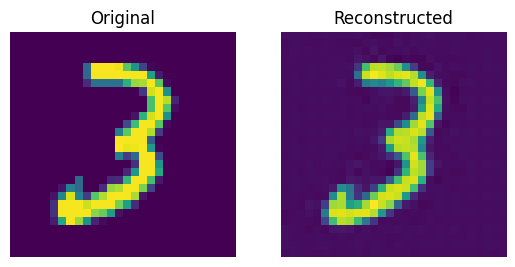

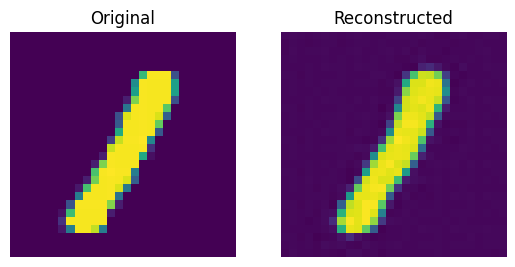

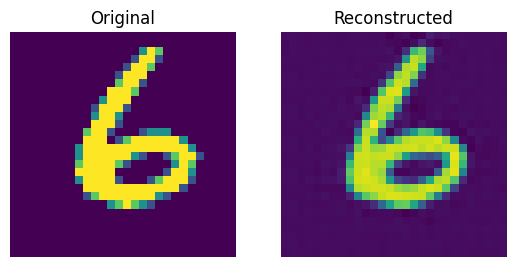

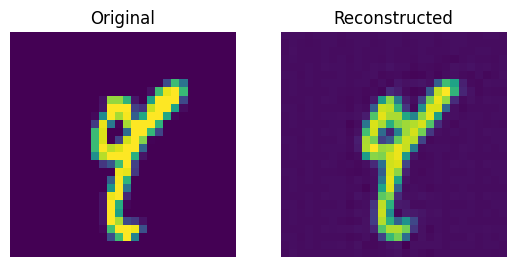

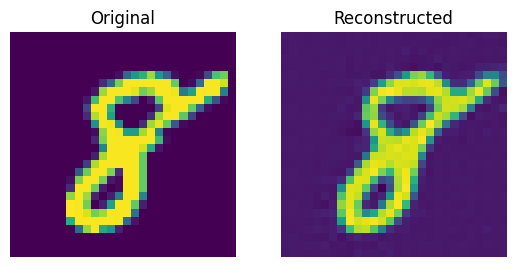

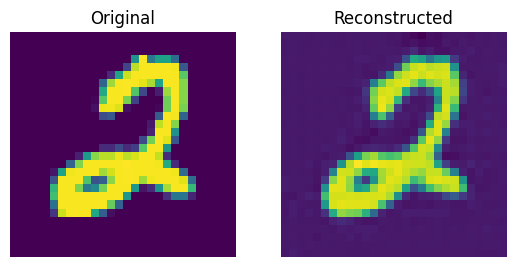

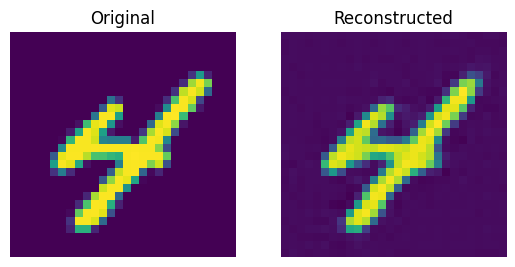

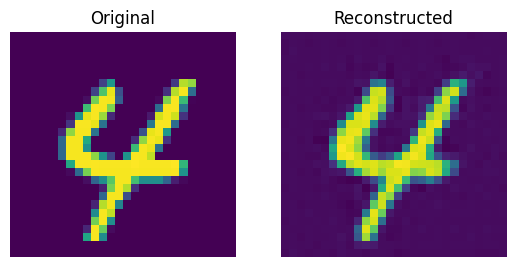

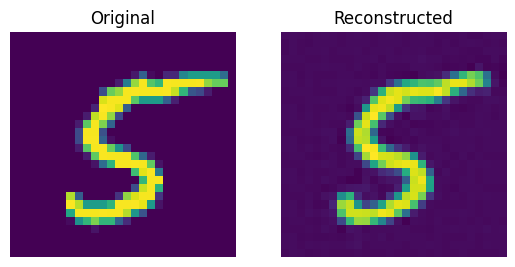

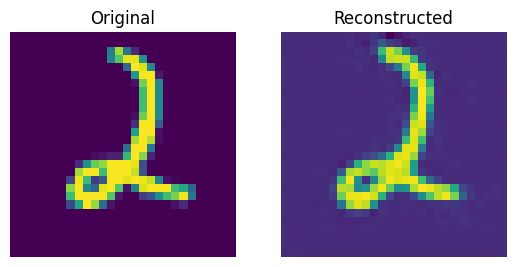

In [17]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze() + 0.5)
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test_scaled), 10)
test_images = x_test_scaled[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

In [19]:
codebook_indices

array([[[ 69, 116,  26,  78,  69,  69,  57],
        [ 69,  69,   1,  51,  54,  69,  57],
        [ 69,  69,  57,  19,  24,  69,  57],
        [ 69,  69,  67,  58,  14,  69,  57],
        [ 69, 112,  37,  88, 120,  69,  57],
        [ 67,  38,  51,  27,  69,  69,  57],
        [ 69,  69,  69,  69,  69,  69,  69]],

       [[ 69,  69,  69,  57, 119,  69,  57],
        [ 69,  69,  69, 101,  32,  69,  57],
        [ 69,  69, 116, 109,  24,  69,  57],
        [ 69,  69,   3,  32,  27,  69,  57],
        [ 69, 110, 109,   1,  69,  69,  57],
        [ 69, 101,  44,  69,  69,  69,  57],
        [ 69,  69,  69,  69,  69,  69,  69]],

       [[ 69,  69,  69,   3,  39,  69,  57],
        [ 69,  69,  37,  60,  69,  69,  57],
        [ 69, 116,  88,  93,  78,  69,  57],
        [ 69,  18, 109, 100, 102,  24,  57],
        [ 69,  92, 109,  72,  88, 120,  57],
        [ 69,  69,  69, 120,  69,  69,  57],
        [ 69,  69,  69,  69,  69,  69,  69]],

       [[ 69,  69,  69,  69,  69,  69,  57],
    

1/1 [==============================] - 0s 58ms/step


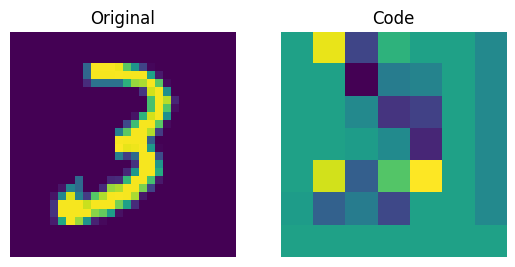

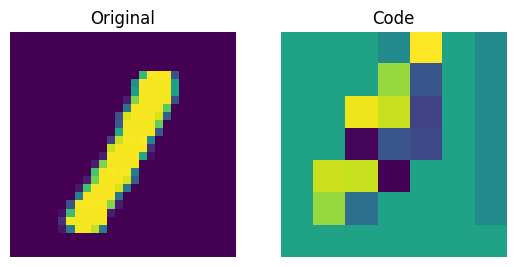

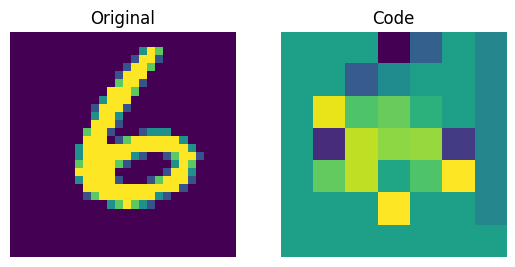

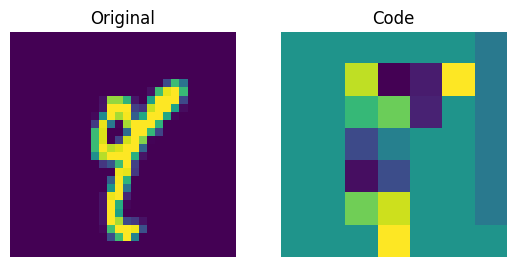

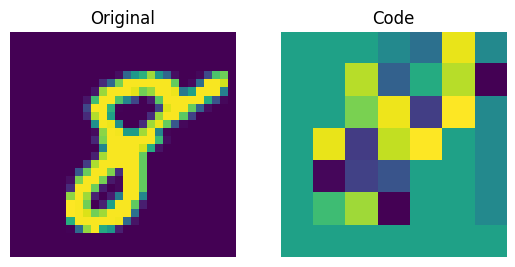

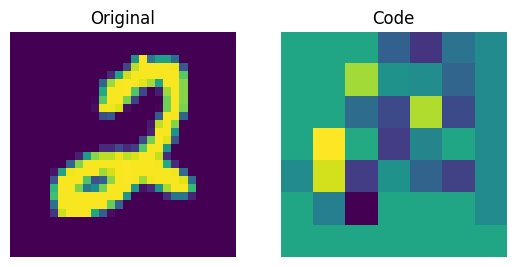

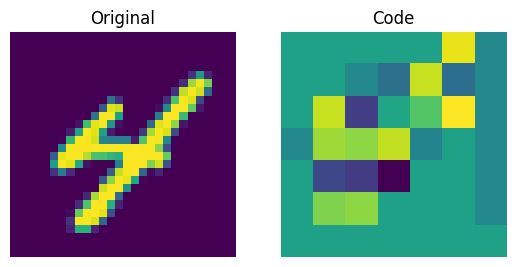

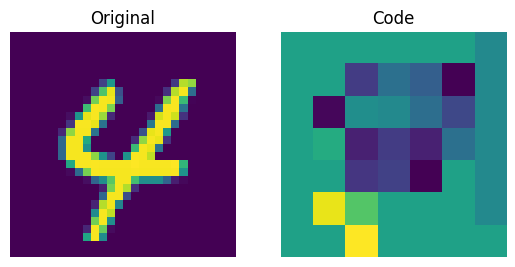

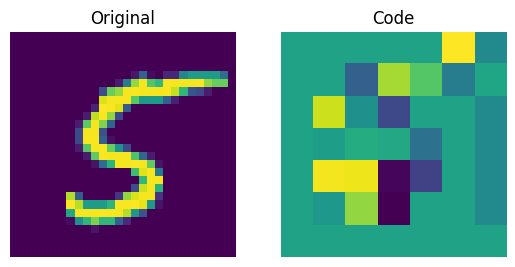

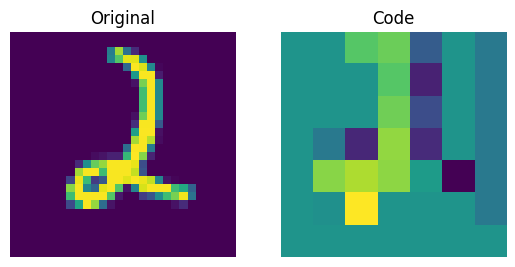

In [18]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

'Q : Is dog cute?'
A